In [ ]:
import os, time, glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
def set_train_rng(seed: int = 1):
    """
    For reproducibility
    """

    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
#!pip install atomai
!pip install git+https://github.com/wdwzyyg/ElectronCounting.git --upgrade


# Training data preprocess

To optimize the training, we applied train data preprocessing steps as listed below:
1. Crop the original 256x256 image data into 64x64 to save RAM for training
2. remove all one-px events

In [ ]:
root = '/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/TrainingData/'
savepath = '/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/TrainingData/QuantizedData64_2morepx/'
for f in range(50):
  box_l = []
  img_l = []
  print("Working on file: ", f)
  imgs = np.load(root+ '%03d'%f + '_img.npz', allow_pickle=True)
  boxes = np.load(root+ '%03d'%f + '_box.npz', allow_pickle=True)
  for i in range(200):
    boxs = boxes['arr_'+str(i)]
    de = []
    for k, value in enumerate(boxs):
      if (value>63).any() or (value<0).any():
        de.append(k)

    boxs = np.delete(boxs, np.array(de).astype('int'), axis=0)

    rows=np.where((boxs[:,0]!=boxs[:,2])|(boxs[:,1]!= boxs[:,3]))
    boxs_out = boxs[rows]


    onepx = np.delete(boxs, rows, axis=0).astype('int')[:,:2]
    im = imgs['arr_'+str(i)]
    im[(onepx[:,0], onepx[:,1])]=0

    box_l.append(boxs_out)
    img_l.append(im)

  np.savez(savepath+ '%03d'%f + '_box.npz', *box_l)
  np.savez(savepath+ '%03d'%f + '_img.npz', *img_l)


In [ ]:
def map01(mat):
    return (mat - mat.min()) / (mat.max() - mat.min())
image = torch.tensor(map01(imgs['arr_0']), dtype=torch.float32)
image = torch.nn.Upsample(scale_factor=2, mode='bilinear')(image[None, None, ...])

Working on file:  10


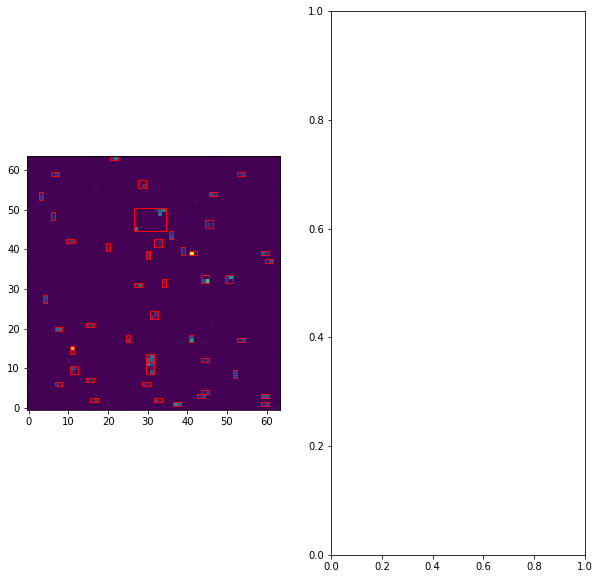

In [ ]:
import matplotlib.patches as patches

for f in range(1):
  f = f + 10
  print("Working on file: ", f)
  imgs = np.load(savepath+ '%03d'%f + '_img.npz', allow_pickle=True)
  boxes = np.load(savepath+ '%03d'%f + '_box.npz', allow_pickle=True)
  fig =  plt.figure(figsize=(10,10))
  ax1, ax2 = fig.subplots(1, 2)
  ax1.imshow(imgs['arr_0'], origin='lower')
  for box in boxes['arr_0']:
    ymin, xmin, ymax, xmax = box
    rect = patches.Rectangle((xmin - 0.5, ymin - 0.5), xmax - xmin+1, ymax - ymin+1, linewidth=1, edgecolor='r',
                              facecolor='none')
    ax1.add_patch(rect)

  plt.show()

# Initiate dataset, model and parameters

In [ ]:
from CountingNN.dataset import GeneralizedDataset
# data_set = GeneralizedDataset('/content/drive/MyDrive/CNN e-detect for Celeritas/Wholeframes/QuantizedData64/', train = True, filestart = 20,filenum=30, expandmask=False, getmask=False, imagesize = 64)
data_set = GeneralizedDataset('/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/TrainingData/QuantizedData64_2morepx/', train = True, threshold=20, upsample=2, filestart = 6,filenum=50, expandmask=False, getmask=False, imagesize = 64)

# file 50 sparsity 10%
# indices = torch.randperm(len(dataset)).tolist()
# d_train, d_test = torch.utils.data.random_split(dataset, [2500, 2500])

In [ ]:
# os.mkdir('/content/drive/MyDrive/CNN e-detect for Celeritas/MaskRCNN/training/attempt13/')
hyperparams = {
    'batch_size': 1,
    'lr': 1e-3,
    'momentum': 0.9,
    'weight_decay': 0.0001,
    'lr_steps': [6, 7],
    'epochs': 15,
    'warmup_iters': 15,
    'print_freq': 200,
    'iters': -1,
    'result_path': '/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/model/model_results_step1.pth',
    'ckpt_path': '/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/model/model_ckp_step1.pth'}

mask_hp = {
    # 'min_size': 128, ##################
    # 'max_size': 128, ##################
    # 'if_normalize': False,
    # 'image_mean': [1.315],
    # 'image_std': [37.62],
    # 'fixed_size': (128,128), ##################
    'crop_max': 64, ##################
    'rpn_loss': 'Agg',
    'rpn_fg_iou_thresh': 0.6, 'rpn_bg_iou_thresh': 0.3, # /\/\/\
    'rpn_batch_size_per_image': 256, 'rpn_positive_fraction': 0.5,
    'rpn_reg_weights': (1., 1., 1., 1.),
    'rpn_pre_nms_top_n_train': 800, 'rpn_pre_nms_top_n_test': 800,
    'rpn_post_nms_top_n_train': 400, 'rpn_post_nms_top_n_test': 400,
    'rpn_nms_thresh': 0.2, # /\/\/\

    'box_loss': 'Agg',
    'rpn_score_thresh': 0, # remove low scoring boxes in RegionProposalNetwork
    'box_fg_iou_thresh': 0.1, 'box_bg_iou_thresh': 0.1, 'box_iou_cpu': False,
    'box_batch_size_per_image': 128, 'box_positive_fraction': 0.75,
    'bbox_reg_weights': (1., 1., 1., 1.),
    'box_score_thresh': 0.1, 'box_nms_thresh': 0.01,
    'box_detections_per_img': 200,

}

In [ ]:
# step1: train rpn
from CountingNN.model import faster_rcnn_fcn

set_train_rng(1)
try:
    model
except:
    print(" ")
else:
    print("Previous model deleted")
    del model, params, optimizer

model = faster_rcnn_fcn(kernel = 3, pretrained = True, num_classes=2, weights_path='/content/drive/MyDrive/CNN e-detect for Celeritas/MaskRCNN/TinySegResNet_statedict_k3nearest.tar',
                        setting_dict=mask_hp).to('cuda')



# pretrained = torch.load('/content/drive/MyDrive/CNN e-detect for Celeritas/MaskRCNN/training/attempt13/model_ckp_step2-9.pth')
# model.load_state_dict(pretrained['model'])

##############################
# for layer in model.backbone.fpn.layer_blocks:
#     list(layer.children())[0].kernel_size = (1,1)
##############################


In [ ]:
from CountingNN.train import Parameters,collate_fn

pms = Parameters(**hyperparams)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=pms.lr, momentum=pms.momentum, weight_decay=pms.weight_decay)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
indices = torch.randperm(len(data_set)).tolist()
dataset_train = torch.utils.data.Subset(data_set, indices[:-int(0.3 * len(data_set))])
dataset_test = torch.utils.data.Subset(data_set, indices[-int(0.3 * len(data_set)):])

print('number of train data :', len(dataset_train))
print('number of test data :', len(dataset_test))

# define training and validation data loaders
d_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=True,num_workers=4,
    collate_fn=collate_fn)

d_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

number of train data : 6160
number of test data : 2640


# 4-STEP alternative training

In [ ]:
from logging import raiseExceptions
import math
import sys

def train_one_epoch(step, model, optimizer, data_loader, device, epoch, param):
    for p in optimizer.param_groups:
        p["lr"] = param.lr_lambda(epoch) * param.lr
    train_loss = []
    iters = len(data_loader) if param.iters < 0 else param.iters
    print('iters per epoch:', iters)
    # iters = len(data_loader)

    #######################################
    model.train()
    if step == 1:
      model.backbone.train(False)
      model.roi_heads.train(False)
    elif step == 2 or step == 4:
      model.backbone.train(False)
      model.rpn.train(False)
    elif step==3:
      model.roi_heads.train(False)
    else:
      raiseExceptions('Use step 1-4')
    #######################################
    A = time.time()
    for i, (images, targets) in enumerate(data_loader):
        num_iters = epoch * len(data_loader) + i
        if num_iters <= param.warmup_iters:
            r = num_iters / param.warmup_iters
            for j, p in enumerate(optimizer.param_groups):
                p["lr"] = r * param.lr_lambda(epoch) * param.lr

        # image = image.to(device)
        # target = {k: v.to(device) for k, v in target.items()}
        # images = list(image.to(device) for image in images)

        images = torch.cat(list(image[None, ...] for image in images))
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        losses = model(images, targets)
        train_loss.append(losses)
        # print([loss for loss in losses.values()])
        total_loss = sum(loss for loss in losses.values())
        total_loss.backward()######!!!!

        # if not math.isfinite(total_loss.item()):
        #     print("Loss is {}, stopping training".format(total_loss.item()))
            # sys.exit(1)
            # break

        # elif training_mode=='rpn':
        #     total_loss[]
        optimizer.step()
        optimizer.zero_grad()

        if num_iters % param.print_freq == 0:
            print("{}\t".format(num_iters), "\t".join("{:.3f}".format(l.item()) for l in losses.values()))

        if i >= iters - 1:
            break

    return train_loss



epoch: 1
lr_epoch: 0.00100, factor: 1.00000
iters per epoch: 6160
0	 0.693	0.172	0.718
200	 0.655	0.703	0.475
400	 0.532	1.039	1.161
600	 0.580	0.212	0.467
800	 0.578	0.184	nan
1000	 0.565	0.461	0.510
1200	 0.594	0.070	0.583
1400	 0.586	0.049	1.308
1600	 0.573	0.333	0.435
1800	 0.585	0.195	0.386
2000	 0.592	0.053	0.424
2200	 0.619	0.055	0.378
2400	 0.578	0.067	0.108
2600	 0.568	0.105	0.286
2800	 0.553	0.312	0.493
3000	 0.492	1.145	0.428
3200	 0.519	0.754	nan
3400	 0.539	0.501	0.256
3600	 0.461	0.107	0.379
3800	 0.502	0.196	0.437
4000	 0.434	0.057	0.811
4200	 0.356	0.038	0.281
4400	 0.518	0.053	nan
4600	 0.256	0.533	1.233
4800	 0.088	0.077	0.576
5000	 0.208	0.040	1.114
5200	 0.280	0.188	0.416
5400	 0.528	0.704	nan
5600	 0.447	1.110	1.961
5800	 0.214	0.064	0.478
6000	 0.589	0.633	0.255

epoch: 2
lr_epoch: 0.00100, factor: 1.00000
iters per epoch: 6160
6200	 0.371	0.324	nan
6400	 0.372	0.132	nan
6600	 0.239	0.056	0.307
6800	 0.270	0.076	0.254
7000	 0.407	0.279	0.333
7200	 0.287	0.069	0.2

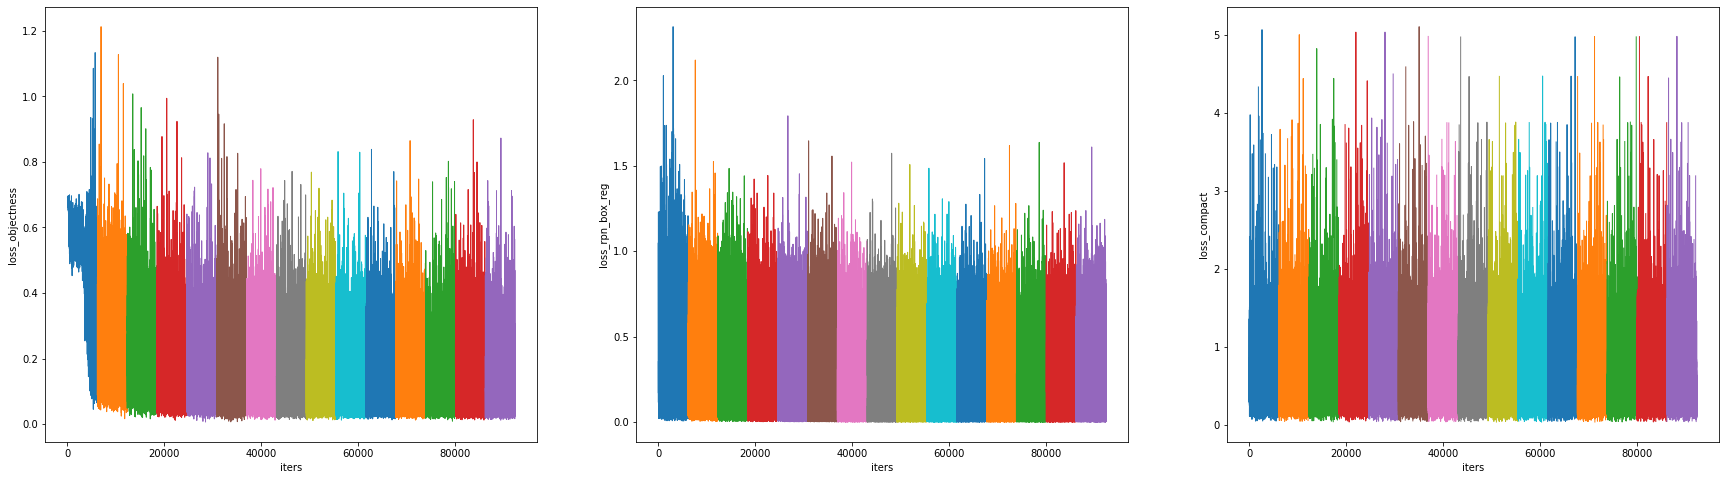

In [ ]:
# STEP 1
import json, glob
from CountingNN.train import plot_train_history
start_epoch = 0
since = time.time()
set_train_rng(1)
for epoch in range(start_epoch, pms.epochs):
    print("\nepoch: {}".format(epoch + 1))
    torch.cuda.empty_cache()

    A = time.time()
    lr_epoch = pms.lr_lambda(epoch) * pms.lr
    print("lr_epoch: {:.5f}, factor: {:.5f}".format(lr_epoch, pms.lr_lambda(epoch)))
    train_loss_out = train_one_epoch(1, model, optimizer, d_train, device, epoch, pms)

    # test_res = evaluate(model, d_test, device, epoch, pms, generate=True)

    trained_epoch = epoch + 1

    # save checkpoint
    checkpoint = {"model": model.state_dict(), "optimizer": optimizer.state_dict(),
                  "epochs": trained_epoch, "losses": {'train_loss': train_loss_out}}

    prefix, ext = os.path.splitext(pms.ckpt_path)
    ckpt_path = "{}-{}{}".format(prefix, trained_epoch, ext)
    torch.save(checkpoint, ckpt_path)
    del checkpoint
    del train_loss_out
    # torch.cuda.empty_cache()
    # -------------------------------------------------------------------------- #

print("\ntotal time of this training: {:.1f} s".format(time.time() - since))

with open(pms.result_path[:-4]+'_hyp.json', 'w+') as fp:
    json.dump(hyperparams, fp)
with open(pms.result_path[:-4]+'_model_p.json', 'w+') as fp:
    json.dump(mask_hp, fp)

if start_epoch < pms.epochs:
    print("already trained: {} epochs\n".format(trained_epoch))

ckpts = glob.glob(prefix + "-*" + ext)
plot_train_history(ckpts)

number of train data : 6160
number of test data : 2640

epoch: 1
lr_epoch: 0.00100, factor: 1.00000
iters per epoch: 6160
0	 0.813	1.121	1.081
200	 0.425	0.601	0.459
400	 0.493	0.604	0.794
600	 0.311	0.382	0.424
800	 0.449	0.536	nan
1000	 0.349	0.472	0.466
1200	 0.411	0.470	0.486
1400	 0.312	0.454	0.751
1600	 0.488	0.590	0.542
1800	 0.400	0.453	0.488
2000	 0.299	0.366	0.349
2200	 0.449	0.420	0.489
2400	 0.289	0.479	0.399
2600	 0.416	0.529	0.351
2800	 0.332	0.677	0.493
3000	 0.447	0.410	0.374
3200	 0.330	0.448	nan
3400	 0.317	0.418	0.373
3600	 0.363	0.361	0.408
3800	 0.380	0.499	0.474
4000	 0.237	0.397	0.671
4200	 0.306	0.293	0.331
4400	 0.339	0.391	nan
4600	 0.354	0.488	0.683
4800	 0.196	0.356	0.350
5000	 0.250	0.409	0.654
5200	 0.201	0.568	0.470
5400	 0.391	0.502	nan
5600	 0.368	0.483	1.290
5800	 0.259	0.393	0.448
6000	 0.267	0.526	0.426

epoch: 2
lr_epoch: 0.00100, factor: 1.00000
iters per epoch: 6160
6200	 0.444	0.482	nan
6400	 0.336	0.491	nan
6600	 0.174	0.328	0.241
6800	 0.271	0.

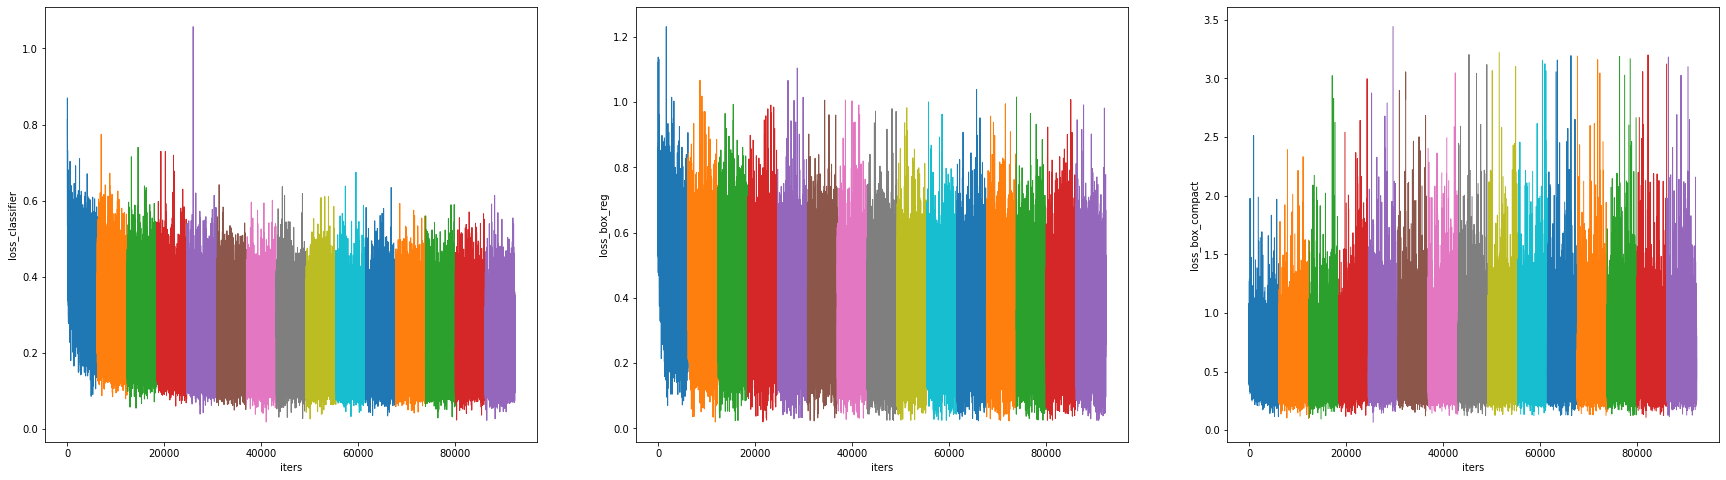

In [ ]:
# STEP2
hyperparams = {
    'batch_size': 1,
    'lr': 1e-3,
    'momentum': 0.9,
    'weight_decay': 0.0001,
    'lr_steps': [6, 7],
    'epochs': 15,
    'warmup_iters': 10,
    'print_freq': 200,
    'iters': -1,
    'result_path': '/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/model/model_results_step2.pth',
    'ckpt_path': '/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/model/model_ckp_step2.pth'}
from CountingNN.train import Parameters,collate_fn

pms = Parameters(**hyperparams)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=pms.lr, momentum=pms.momentum, weight_decay=pms.weight_decay)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
indices = torch.randperm(len(data_set)).tolist()
dataset_train = torch.utils.data.Subset(data_set, indices[:-int(0.3 * len(data_set))])
dataset_test = torch.utils.data.Subset(data_set, indices[-int(0.3 * len(data_set)):])

print('number of train data :', len(dataset_train))
print('number of test data :', len(dataset_test))

# define training and validation data loaders
d_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=True,num_workers=4,
    collate_fn=collate_fn)

d_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)



start_epoch = 0
since = time.time()
set_train_rng(1)
for epoch in range(start_epoch, pms.epochs):
    print("\nepoch: {}".format(epoch + 1))
    torch.cuda.empty_cache()

    A = time.time()
    lr_epoch = pms.lr_lambda(epoch) * pms.lr
    print("lr_epoch: {:.5f}, factor: {:.5f}".format(lr_epoch, pms.lr_lambda(epoch)))
    train_loss_out = train_one_epoch(2, model, optimizer, d_train, device, epoch, pms)

    # test_res = evaluate(model, d_test, device, epoch, pms, generate=True)

    trained_epoch = epoch + 1

    # save checkpoint
    checkpoint = {"model": model.state_dict(), "optimizer": optimizer.state_dict(),
                  "epochs": trained_epoch, "losses": {'train_loss': train_loss_out}}

    prefix, ext = os.path.splitext(pms.ckpt_path)
    ckpt_path = "{}-{}{}".format(prefix, trained_epoch, ext)
    torch.save(checkpoint, ckpt_path)
    del checkpoint
    del train_loss_out
    # torch.cuda.empty_cache()
    # -------------------------------------------------------------------------- #

print("\ntotal time of this training: {:.1f} s".format(time.time() - since))

with open(pms.result_path[:-4]+'_hyp.json', 'w+') as fp:
    json.dump(hyperparams, fp)
with open(pms.result_path[:-4]+'_model_p.json', 'w+') as fp:
    json.dump(mask_hp, fp)

if start_epoch < pms.epochs:
    print("already trained: {} epochs\n".format(trained_epoch))

ckpts = glob.glob(prefix + "-*" + ext)
plot_train_history(ckpts)

number of train data : 6160
number of test data : 2640

epoch: 1
lr_epoch: 0.00100, factor: 1.00000
iters per epoch: 6160
0	 0.266	0.149	0.562
200	 0.122	0.533	0.450
400	 0.169	0.696	1.011
600	 0.065	0.145	0.455
800	 0.089	0.140	nan
1000	 0.123	0.367	0.484
1200	 0.091	0.027	0.593
1400	 0.046	0.009	1.332
1600	 0.178	0.247	0.382
1800	 0.088	0.130	0.377
2000	 0.101	0.044	0.451
2200	 0.109	0.028	0.386
2400	 0.085	0.013	0.108
2600	 0.078	0.053	0.275
2800	 0.118	0.244	0.450
3000	 0.208	0.903	0.452
3200	 0.207	0.484	nan
3400	 0.111	0.401	0.239
3600	 0.123	0.038	0.325
3800	 0.099	0.135	0.420
4000	 0.055	0.022	0.801
4200	 0.051	0.005	0.239
4400	 0.067	0.022	nan
4600	 0.129	0.323	1.145
4800	 0.045	0.023	0.478
5000	 0.037	0.011	1.057
5200	 0.138	0.179	0.395
5400	 0.297	0.512	nan
5600	 0.135	0.963	1.831
5800	 0.073	0.033	0.490
6000	 0.469	0.480	0.219

epoch: 2
lr_epoch: 0.00100, factor: 1.00000
iters per epoch: 6160
6200	 0.274	0.295	nan
6400	 0.164	0.100	nan
6600	 0.063	0.060	0.331
6800	 0.122	0.

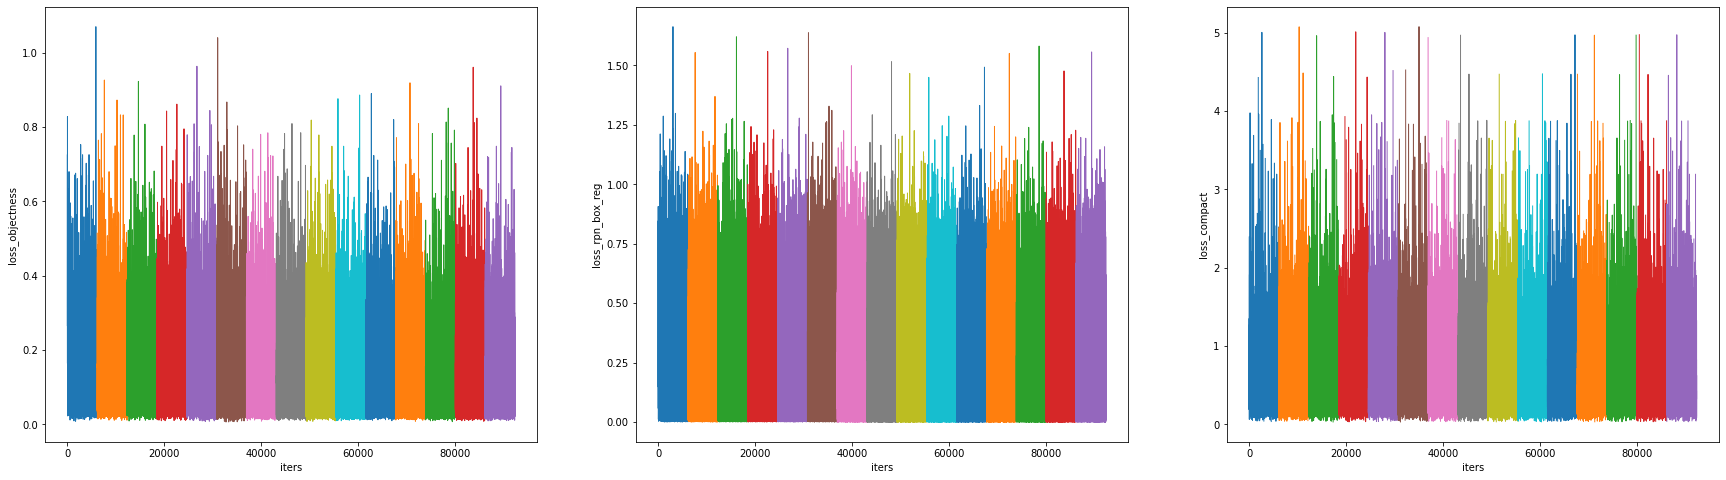

In [ ]:
#STEP3
hyperparams = {
    'batch_size': 1,
    'lr': 1e-3,
    'momentum': 0.9,
    'weight_decay': 0.0001,
    'lr_steps': [6, 7],
    'epochs': 15,
    'warmup_iters': 10,
    'print_freq': 200,
    'iters': -1,
    'result_path': '/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/model/model_results_step3.pth',
    'ckpt_path': '/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/model/model_ckp_step3.pth'}
from CountingNN.train import Parameters,collate_fn

pms = Parameters(**hyperparams)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=pms.lr, momentum=pms.momentum, weight_decay=pms.weight_decay)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
indices = torch.randperm(len(data_set)).tolist()
dataset_train = torch.utils.data.Subset(data_set, indices[:-int(0.3 * len(data_set))])
dataset_test = torch.utils.data.Subset(data_set, indices[-int(0.3 * len(data_set)):])

print('number of train data :', len(dataset_train))
print('number of test data :', len(dataset_test))

# define training and validation data loaders
d_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=True,num_workers=4,
    collate_fn=collate_fn)

d_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)



start_epoch = 0
since = time.time()
set_train_rng(1)
for epoch in range(start_epoch, pms.epochs):
    print("\nepoch: {}".format(epoch + 1))
    torch.cuda.empty_cache()

    A = time.time()
    lr_epoch = pms.lr_lambda(epoch) * pms.lr
    print("lr_epoch: {:.5f}, factor: {:.5f}".format(lr_epoch, pms.lr_lambda(epoch)))
    train_loss_out = train_one_epoch(3, model, optimizer, d_train, device, epoch, pms)

    # test_res = evaluate(model, d_test, device, epoch, pms, generate=True)

    trained_epoch = epoch + 1

    # save checkpoint
    checkpoint = {"model": model.state_dict(), "optimizer": optimizer.state_dict(),
                  "epochs": trained_epoch, "losses": {'train_loss': train_loss_out}}

    prefix, ext = os.path.splitext(pms.ckpt_path)
    ckpt_path = "{}-{}{}".format(prefix, trained_epoch, ext)
    torch.save(checkpoint, ckpt_path)
    del checkpoint
    del train_loss_out
    # torch.cuda.empty_cache()
    # -------------------------------------------------------------------------- #

print("\ntotal time of this training: {:.1f} s".format(time.time() - since))

with open(pms.result_path[:-4]+'_hyp.json', 'w+') as fp:
    json.dump(hyperparams, fp)
with open(pms.result_path[:-4]+'_model_p.json', 'w+') as fp:
    json.dump(mask_hp, fp)

if start_epoch < pms.epochs:
    print("already trained: {} epochs\n".format(trained_epoch))

ckpts = glob.glob(prefix + "-*" + ext)
plot_train_history(ckpts)

number of train data : 6160
number of test data : 2640

epoch: 1
lr_epoch: 0.00100, factor: 1.00000
iters per epoch: 6160
0	 1.700	0.708	0.961
200	 0.332	0.383	0.307
400	 0.447	0.419	0.696
600	 0.171	0.297	0.401
800	 0.318	0.374	nan
1000	 0.343	0.388	0.430
1200	 0.298	0.269	0.411
1400	 0.167	0.238	0.739
1600	 0.491	0.605	0.572
1800	 0.377	0.406	0.476
2000	 0.232	0.259	0.351
2200	 0.392	0.294	0.411
2400	 0.213	0.282	0.237
2600	 0.291	0.338	0.333
2800	 0.233	0.641	0.504
3000	 0.469	0.518	0.566
3200	 0.330	0.370	nan
3400	 0.345	0.368	0.379
3600	 0.363	0.353	0.447
3800	 0.305	0.457	0.467
4000	 0.259	0.248	0.731
4200	 0.149	0.177	0.314
4400	 0.236	0.295	nan
4600	 0.372	0.431	0.757
4800	 0.156	0.277	0.453
5000	 0.298	0.209	0.722
5200	 0.294	0.597	0.455
5400	 0.397	0.513	nan
5600	 0.243	0.601	1.401
5800	 0.238	0.291	0.335
6000	 0.307	0.327	0.323

epoch: 2
lr_epoch: 0.00100, factor: 1.00000
iters per epoch: 6160
6200	 0.542	0.423	nan
6400	 0.409	0.440	nan
6600	 0.124	0.239	0.261
6800	 0.210	0.

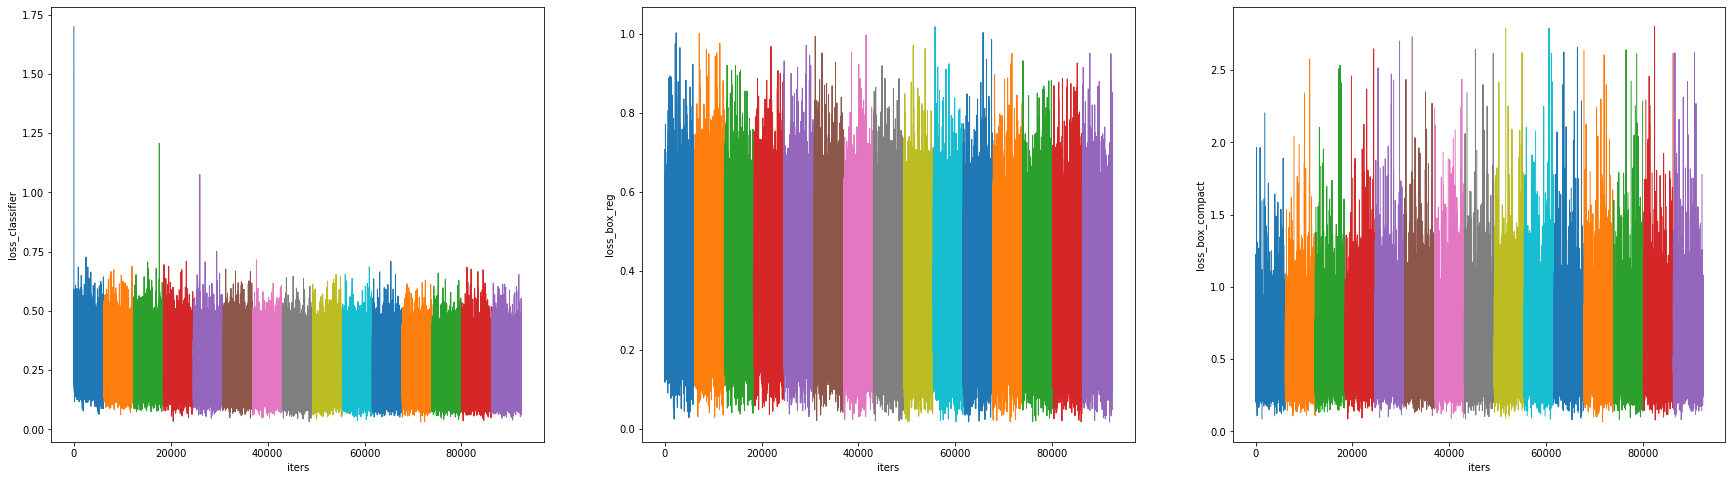

In [ ]:
#STEP4
hyperparams = {
    'batch_size': 1,
    'lr': 1e-3,
    'momentum': 0.9,
    'weight_decay': 0.0001,
    'lr_steps': [6, 7],
    'epochs': 15,
    'warmup_iters': 10,
    'print_freq': 200,
    'iters': -1,
    'result_path': '/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/model/model_results_step4.pth',
    'ckpt_path': '/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/model/model_ckp_step4.pth'}
from CountingNN.train import Parameters,collate_fn

pms = Parameters(**hyperparams)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=pms.lr, momentum=pms.momentum, weight_decay=pms.weight_decay)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
indices = torch.randperm(len(data_set)).tolist()
dataset_train = torch.utils.data.Subset(data_set, indices[:-int(0.3 * len(data_set))])
dataset_test = torch.utils.data.Subset(data_set, indices[-int(0.3 * len(data_set)):])

print('number of train data :', len(dataset_train))
print('number of test data :', len(dataset_test))

# define training and validation data loaders
d_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=True,num_workers=4,
    collate_fn=collate_fn)

d_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)



start_epoch = 0
since = time.time()
set_train_rng(1)
for epoch in range(start_epoch, pms.epochs):
    print("\nepoch: {}".format(epoch + 1))
    torch.cuda.empty_cache()

    A = time.time()
    lr_epoch = pms.lr_lambda(epoch) * pms.lr
    print("lr_epoch: {:.5f}, factor: {:.5f}".format(lr_epoch, pms.lr_lambda(epoch)))
    train_loss_out = train_one_epoch(4, model, optimizer, d_train, device, epoch, pms)

    # test_res = evaluate(model, d_test, device, epoch, pms, generate=True)

    trained_epoch = epoch + 1

    # save checkpoint
    checkpoint = {"model": model.state_dict(), "optimizer": optimizer.state_dict(),
                  "epochs": trained_epoch, "losses": {'train_loss': train_loss_out}}

    prefix, ext = os.path.splitext(pms.ckpt_path)
    ckpt_path = "{}-{}{}".format(prefix, trained_epoch, ext)
    torch.save(checkpoint, ckpt_path)
    del checkpoint
    del train_loss_out
    # torch.cuda.empty_cache()
    # -------------------------------------------------------------------------- #

print("\ntotal time of this training: {:.1f} s".format(time.time() - since))

with open(pms.result_path[:-4]+'_hyp.json', 'w+') as fp:
    json.dump(hyperparams, fp)
with open(pms.result_path[:-4]+'_model_p.json', 'w+') as fp:
    json.dump(mask_hp, fp)

if start_epoch < pms.epochs:
    print("already trained: {} epochs\n".format(trained_epoch))

ckpts = glob.glob(prefix + "-*" + ext)
plot_train_history(ckpts)

In [ ]:
torch.save(model, '/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/model/model_200kV_final.pt')


In [ ]:
import torch
torch.save({'state_dict': model.state_dict()}, '/content/drive/MyDrive/CNN e-detect for Celeritas/new_200kV_data/model/model_200kV_final_state_dict.tar')